In [1]:
import sys

#Import libraries
#import scanorama
import time
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import copy
import itertools
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)


sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=300)

/scratch/lgirish/ipykernel_1096532/1343465429.py:38: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


In [2]:
path = '/wynton/home/sinha/lgirish/ashouri_lab/'  
adata_file = path + 'GSE185577_adata_only_T_cells.h5ad'  
adata = sc.read(adata_file)  
print("done")

done


In [3]:
adata

AnnData object with n_obs × n_vars = 99074 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata_subset = adata[adata.obs['TRBV'] != 'None']

In [5]:
np.unique(adata_subset.obs['TRBV'])

array(['TRBV1', 'TRBV10', 'TRBV12-1', 'TRBV12-2', 'TRBV12-2+TRBV13-2',
       'TRBV13-1', 'TRBV13-2', 'TRBV13-3', 'TRBV14', 'TRBV15', 'TRBV16',
       'TRBV17', 'TRBV19', 'TRBV2', 'TRBV20', 'TRBV21', 'TRBV23',
       'TRBV26', 'TRBV29', 'TRBV3', 'TRBV30', 'TRBV31', 'TRBV4', 'TRBV5'],
      dtype=object)

In [6]:
adata_subset

View of AnnData object with n_obs × n_vars = 81778 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
adata_subset = adata_subset[["_" not in x for x in list(adata_subset.obs['TRAV'])]]
adata_subset

View of AnnData object with n_obs × n_vars = 71590 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
subtype_loc = {"WT_High":[2,6], "WT_Low":[3,7], "SKG_High":[0,4], "SKG_Low":[1,5]}

TCR_beta_var = {}
gene_list_TRB = list()
barcodes = list() #will store number of cells with productive TCR
for i in range(len(np.unique(adata_subset.obs['batch']))):
    adata_subset_2 = adata_subset[[x == str(i) for x in adata_subset.obs['batch']]]
    genes, counts = np.unique(adata_subset_2.obs['TRBV'], return_counts=True)
    TCR_beta_var[i] = dict(zip(genes, counts))
    gene_list_TRB += list(genes)
    barcodes.append(adata_subset_2.shape[0])

gene_list_TRB = sorted(list(set(gene_list_TRB)))    

gene_dictionary_TRB = {}
num_batches = len(np.unique(adata_subset.obs['batch']))

for gene in gene_list_TRB:
    counts_for_genes = [0] * num_batches
    for i in range(num_batches): 
        counts_for_genes[i] = TCR_beta_var[i].get(gene, 0) 
    gene_dictionary_TRB[gene] = counts_for_genes

skg_diff = list()
value_avg = list()
subgroup_presence = list()
two_mice_present  = list()
#Create ordering for gene list
for gene in list(gene_dictionary_TRB.keys()):

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRB[gene],barcodes)]
    skg_mean = np.mean([values[0]-values[1], values[4]-values[5]])

    skg_diff = skg_diff + [skg_mean]
    value_avg = value_avg + [np.mean(values)]
    #present in at least two mice of the same genotype
    subgroup_presence = subgroup_presence + [(values[0] >0 and values[4] > 0) or (values[1] >0 and values[5] > 0) or (values[2] >0 and values[6] > 0) or (values[3] >0 and values[7] > 0)]

    two_mice_present = two_mice_present + [np.sum([x>0 for x in values]) >= 2]

gene_list = pd.DataFrame.from_dict({"genes":list(gene_dictionary_TRB.keys()), "mean":skg_diff, "avg":value_avg, "subgroup": subgroup_presence, "two_mice": two_mice_present})

genes = list(gene_dictionary_TRB.keys())
genes.remove('TRBV10')
genes.remove('TRBV12-2+TRBV13-2') 
genes.remove('TRBV21')

In [9]:
#SKG_GFPhi vs SKG_GFPlo

In [10]:
import scipy
from scipy import stats
gene_relative_delta_skg = {}
for gene in genes:

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRB[gene],barcodes)]
    skg_hi_mean = np.mean([values[0], values[4]])
    skg_lo_mean = np.mean([values[1], values[5]])
    t_statistic = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[0]
    p_value = stats.ttest_rel([values[x] for x in [0,4]], [values[x] for x in [1,5]])[1]
   
    gene_relative_delta_skg[gene] = [p_value, skg_hi_mean, skg_lo_mean, skg_hi_mean > skg_lo_mean, t_statistic]
    
import statsmodels.stats.multitest
adj_p_values = statsmodels.stats.multitest.fdrcorrection([x[0]/2 for x in list(gene_relative_delta_skg.values())])[1]

nr4a1_genes = pd.DataFrame.from_dict(gene_relative_delta_skg)
nr4a1_genes.index = ["Paired p value","Mean SKG High", "Mean WT High", "SKG High > WT High?", "t statistic"]
nr4a1_genes.loc["Paired p value",:] = [x/2 for x in list(nr4a1_genes.loc["Paired p value",:])]
nr4a1_genes.loc["Adj p value",:] = list(adj_p_values)

In [11]:
color_list = list()
for x,y in zip(adj_p_values, [x[4] for x in list(gene_relative_delta_skg.values())]):
    if x == 0.5:
        color_list = color_list +["#808080"]
    elif x > 0.1:
        color_list = color_list +["#000000"]
    elif y > 0:
        color_list = color_list + ["#1f77b4"]
    
    else:
        color_list = color_list + ["#aec7e8"]

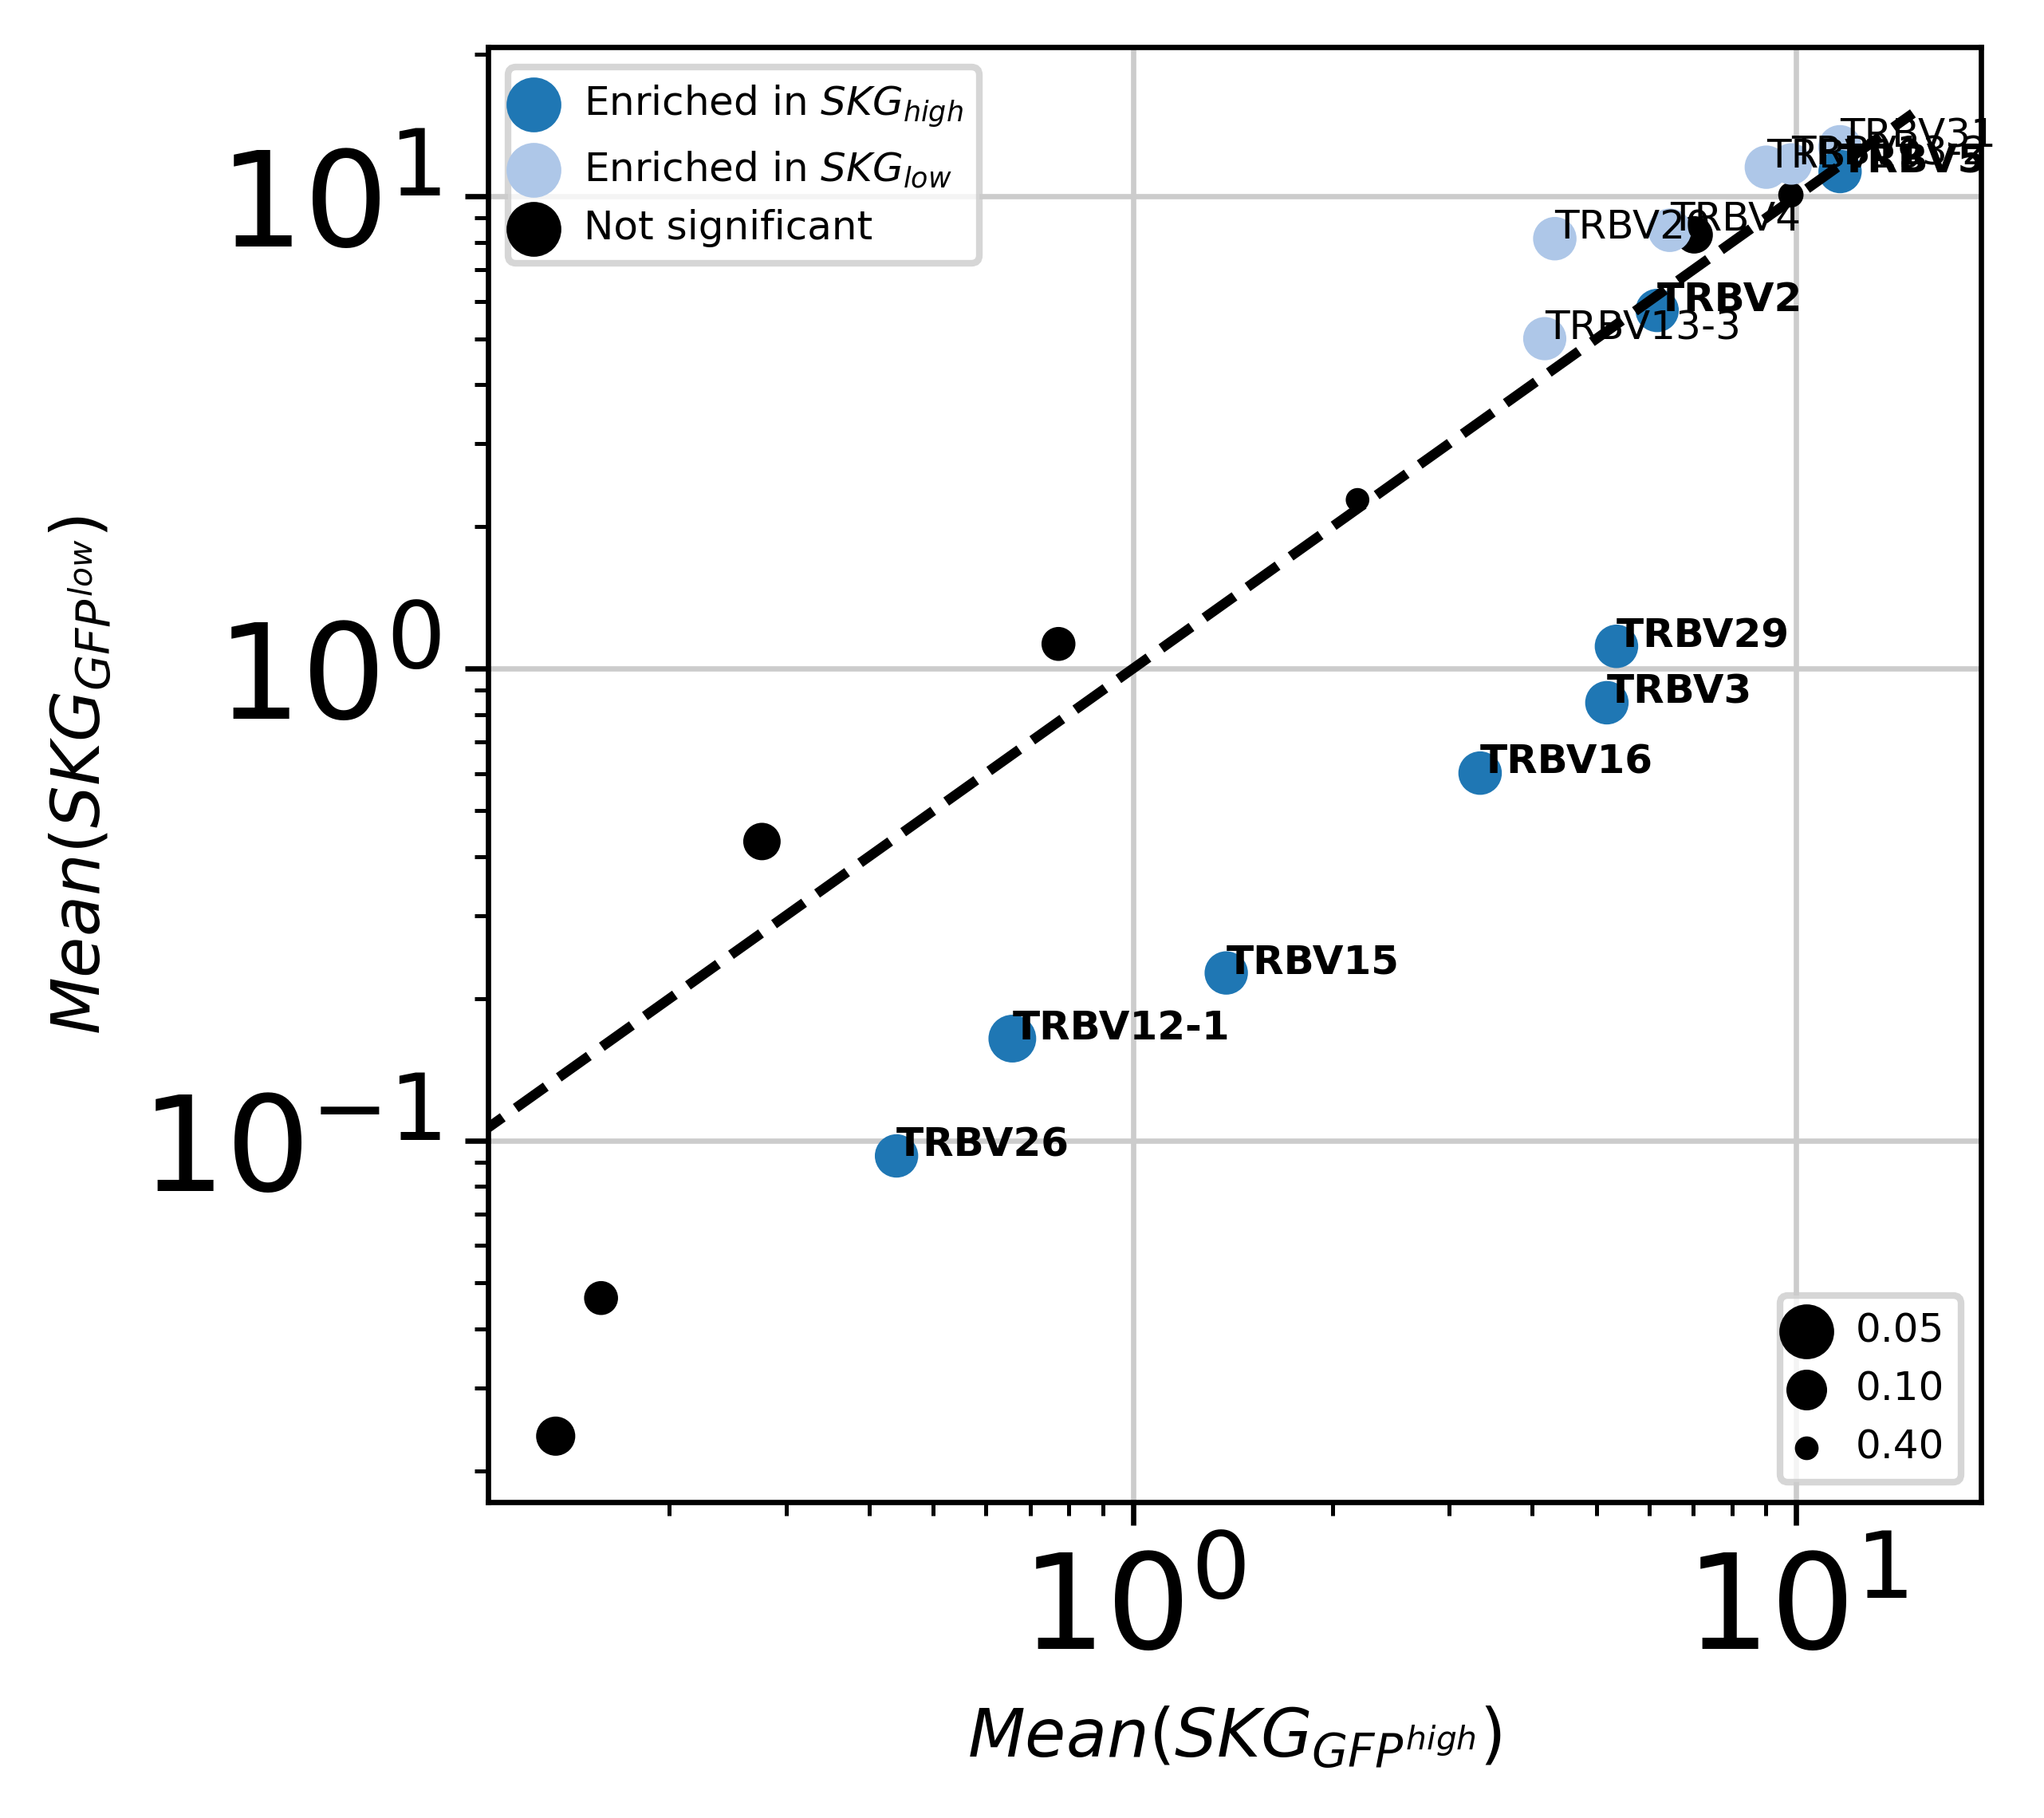

In [12]:
#file_save_prefix = 

plt.rc('axes', axisbelow=True)
extra_value = 20
division_value = 8
plt.scatter([x[1] for x in list(gene_relative_delta_skg.values())], [x[2] for x in list(gene_relative_delta_skg.values())],
            s = [(np.exp(-np.log(x))+extra_value/x)/division_value  for x in adj_p_values], edgecolors=color_list, color =  color_list)


plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("$Mean(SKG_{GFP^{high}})$", size=10)
plt.ylabel("$Mean(SKG_{GFP^{low}})$", size=10)
plt.plot([0,15],[0,15], color = 'black', linestyle = '--')
plt.xscale('log')
plt.yscale('log')

x = [i for i in [x[1] for x in list(gene_relative_delta_skg.values())]]
y = [i for i in [x[2] for x in list(gene_relative_delta_skg.values())]]
p = [i for i in adj_p_values]
labels = list(gene_relative_delta_skg.keys())
bold_dic = {True:"bold", False:"normal"}
p_value_cutoff = 0.1
for i,txt in enumerate(labels):
    if ((p[i] < p_value_cutoff) and (x[i]> y[i] and color_list[i] == "#1f77b4")):
        plt.annotate(txt, (x[i], y[i]), size = 6, weight = "bold")
        #print(txt, p[i])
    elif (p[i] < p_value_cutoff):
        plt.annotate(txt, (x[i], y[i]), size = 6)
        #print(txt, p[i])


l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#1f77b4",  color = "#1f77b4")
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#aec7e8",  color = "#aec7e8")
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = "black")

labels = ["Enriched in $SKG_{high}$", "Enriched in $SKG_{low}$", "Not significant"]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 2, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

legend_color = 'black'
#l1 = plt.scatter([],[], s=np.exp(-np.log(0.01))+extra_value, edgecolors='black',  color = legend_color)
l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = legend_color)
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.10))+extra_value/0.10)/division_value, edgecolors='black',  color = legend_color)
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.4))+extra_value/0.4)/division_value, edgecolors='black',   color = legend_color)

labels = ["0.05", "0.10", "0.40"]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 4, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

plt.gca().add_artist(leg)
#plt.savefig(file_save_prefix + "fig_4_TCR_TRA_all_cells_scatterplot_SKG_high_v_WT_high_labelled" + ".svg", format="svg")
plt.show()
plt.close()


In [13]:
gene_df = pd.DataFrame.from_dict(gene_relative_delta_skg, orient='index',
                                 columns=["Paired p value", "Mean SKG High", "Mean SKG Low", "SKG High > SKG Low?", "t statistic"])

# Add adjusted p-values
gene_df["Adj p value"] = adj_p_values

# Save to CSV
gene_df.to_csv(path + "TCR_beta_diff_stats.csv")

In [14]:
#WT_GFPhi vs WT_GFPlo

In [15]:
import scipy 
from scipy import stats
gene_relative_delta_wt = {}
for gene in genes:

    labels = ["SKG_High","SKG_Low","WT_High", "WT_Low","SKG_High","SKG_Low","WT_High", "WT_Low"]
    values = [x/y*100 for x,y in zip(gene_dictionary_TRB[gene],barcodes)]
    wt_hi_mean = np.mean([values[2], values[6]])
    wt_lo_mean = np.mean([values[3], values[7]])
    t_statistic = stats.ttest_rel([values[x] for x in [2, 6]], [values[x] for x in [3, 7]])[0]
    p_value = stats.ttest_rel([values[x] for x in [2, 6]], [values[x] for x in [3, 7]])[1]

    gene_relative_delta_wt[gene] = [p_value, wt_hi_mean, wt_lo_mean, wt_hi_mean > wt_lo_mean, t_statistic]
    
import statsmodels.stats.multitest
adj_p_values = statsmodels.stats.multitest.fdrcorrection([x[0]/2 for x in list(gene_relative_delta_wt.values())])[1]

In [16]:
nr4a1_genes = pd.DataFrame.from_dict(gene_relative_delta_wt)
nr4a1_genes.index = ["Paired p value","Mean SKG High", "Mean WT High", "SKG High > WT High?", "t statistic"]
nr4a1_genes.loc["Paired p value",:] = [x/2 for x in list(nr4a1_genes.loc["Paired p value",:])]
nr4a1_genes.loc["Adj p value",:] = list(adj_p_values)

In [17]:
color_list = list()
for x,y in zip(adj_p_values, [x[4] for x in list(gene_relative_delta_wt.values())]):
    if x > 0.1:
        color_list = color_list +["#000000"]
    elif y > 0:
        color_list = color_list + ["#1f77b4"]
    else:
        color_list = color_list + ["#aec7e8"]

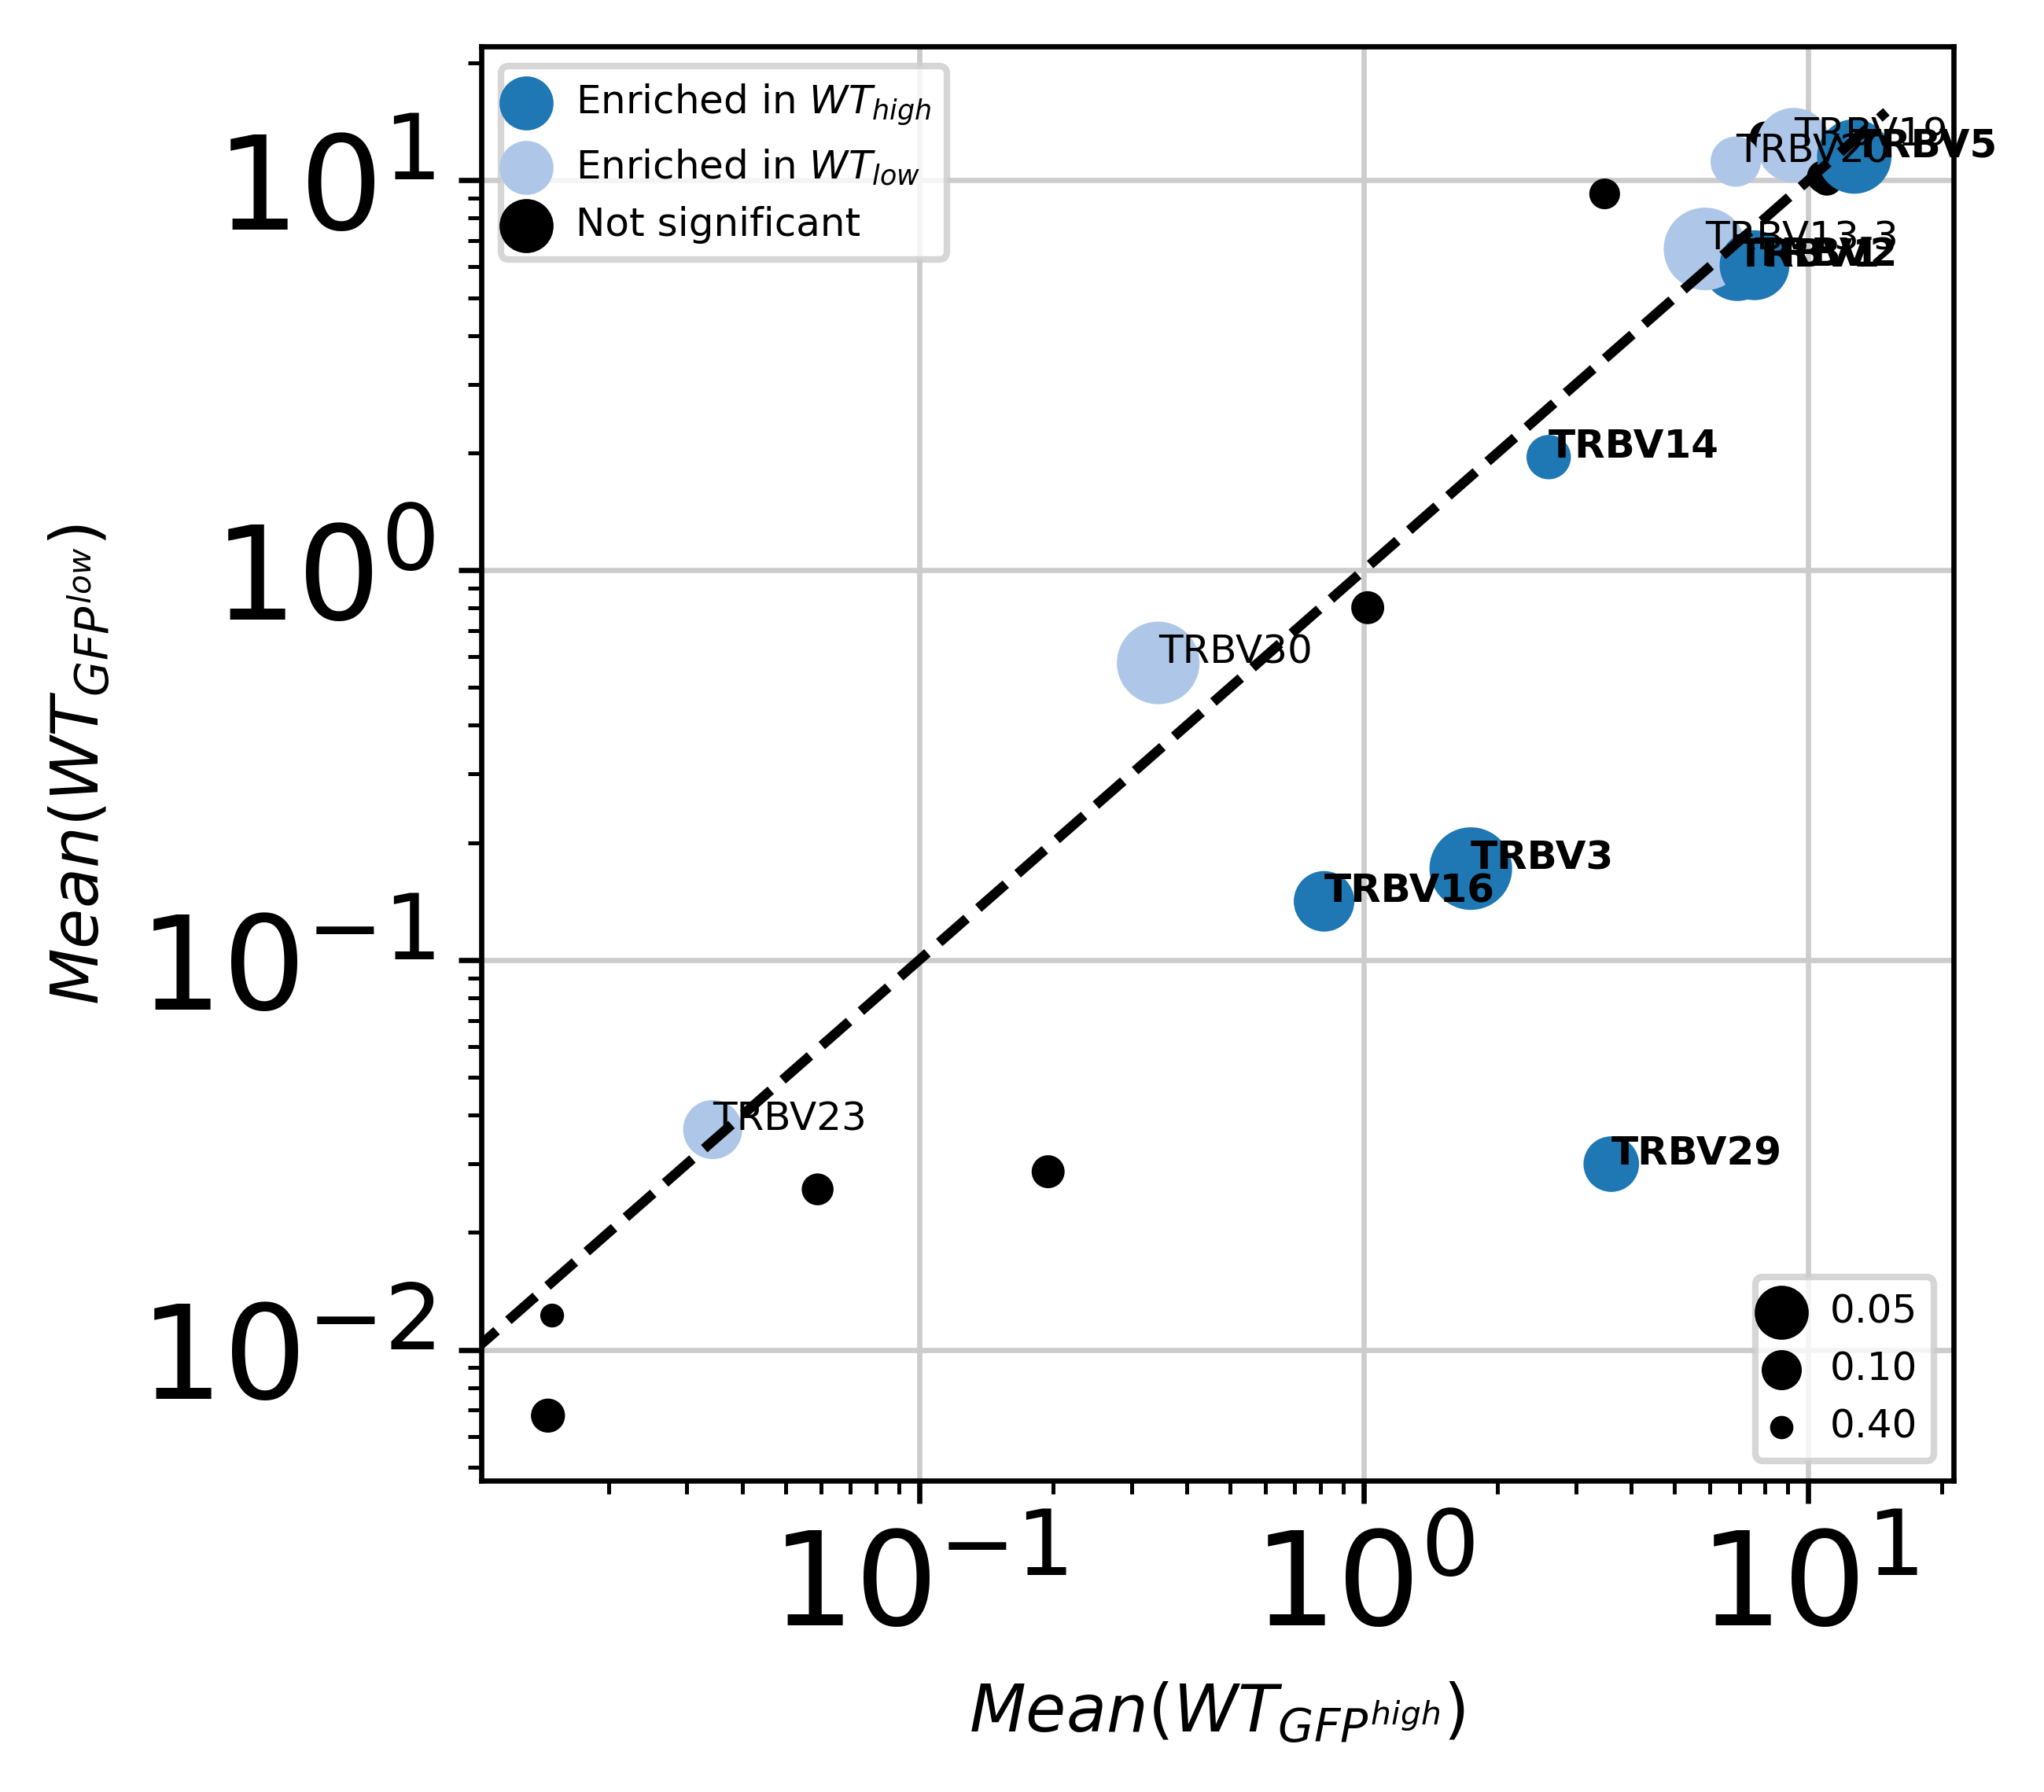

In [18]:
#file_save_prefix = 

plt.rc('axes', axisbelow=True)
extra_value = 20
division_value = 8
plt.scatter([x[1] for x in list(gene_relative_delta_wt.values())], [x[2] for x in list(gene_relative_delta_wt.values())],
            s = [(np.exp(-np.log(x))+extra_value/x)/division_value  for x in adj_p_values], edgecolors=color_list, color =  color_list)


plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("$Mean(WT_{GFP^{high}})$", size=10)
plt.ylabel("$Mean(WT_{GFP^{low}})$", size=10)
plt.plot([0,15],[0,15], color = 'black', linestyle = '--')
plt.xscale('log')
plt.yscale('log')

x = [i for i in [x[1] for x in list(gene_relative_delta_wt.values())]]
y = [i for i in [x[2] for x in list(gene_relative_delta_wt.values())]]
p = [i for i in adj_p_values]
labels = list(gene_relative_delta_wt.keys())
bold_dic = {True:"bold", False:"normal"}
p_value_cutoff = 0.1
for i,txt in enumerate(labels):
    if ((p[i] < p_value_cutoff) and (x[i]> y[i] and color_list[i] == "#1f77b4")):
        plt.annotate(txt, (x[i], y[i]), size = 6, weight = "bold")
        #print(txt, p[i])
    elif (p[i] < p_value_cutoff):
        plt.annotate(txt, (x[i], y[i]), size = 6)
        #print(txt, p[i])


l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#1f77b4",  color = "#1f77b4")
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors="#aec7e8",  color = "#aec7e8")
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = "black")

labels = ["Enriched in $WT_{high}$", "Enriched in $WT_{low}$", "Not significant"]

leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 2, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

legend_color = 'black'
#l1 = plt.scatter([],[], s=np.exp(-np.log(0.01))+extra_value, edgecolors='black',  color = legend_color)
l1 = plt.scatter([],[], s=(np.exp(-np.log(0.05))+extra_value/0.05)/division_value, edgecolors='black',  color = legend_color)
l2 = plt.scatter([],[], s=(np.exp(-np.log(0.10))+extra_value/0.10)/division_value, edgecolors='black',  color = legend_color)
l3 = plt.scatter([],[], s=(np.exp(-np.log(0.4))+extra_value/0.4)/division_value, edgecolors='black',   color = legend_color)

labels = ["0.05", "0.10", "0.40"]

plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=6,#handlelength=2, 
                 loc = 4, #borderpad = 1.8,
handletextpad=1, #title='My Title'
                 scatterpoints = 1)

plt.gca().add_artist(leg)
#plt.savefig(file_save_prefix + "fig_4_TCR_TRA_all_cells_scatterplot_SKG_high_v_WT_high_labelled" + ".svg", format="svg")
plt.show()
plt.close()

In [20]:
import pandas as pd
import statsmodels.stats.multitest

# 1. Raw p-values for FDR correction
skg_pvals_raw = [x[0]/2 for x in gene_relative_delta_skg.values()]
wt_pvals_raw = [x[0]/2 for x in gene_relative_delta_wt.values()]
genes = list(gene_relative_delta_skg.keys())

# 2. FDR correction
skg_adj_pvals = statsmodels.stats.multitest.fdrcorrection(skg_pvals_raw)[1]
wt_adj_pvals = statsmodels.stats.multitest.fdrcorrection(wt_pvals_raw)[1]

# 3. Compute mean frequencies (%) in each group
group_indices = {
    'SKG_High': [0, 4],
    'SKG_Low': [1, 5],
    'WT_High': [2, 6],
    'WT_Low': [3, 7],
}

def mean_freq(gene, indices):
    values = [x/y * 100 for x, y in zip(gene_dictionary_TRB[gene], barcodes)]
    return sum([values[i] for i in indices]) / len(indices)

skg_hi_freqs = [mean_freq(g, group_indices['SKG_High']) for g in genes]
skg_lo_freqs = [mean_freq(g, group_indices['SKG_Low']) for g in genes]
wt_hi_freqs = [mean_freq(g, group_indices['WT_High']) for g in genes]
wt_lo_freqs = [mean_freq(g, group_indices['WT_Low']) for g in genes]

# 4. Combine into frequency table
freq_table = pd.DataFrame({
    'TRBV_gene': genes,
    'SKG High Mean': skg_hi_freqs,
    'SKG Low Mean': skg_lo_freqs,
    'SKG High vs Low Adj pval': skg_adj_pvals,
    'WT High Mean': wt_hi_freqs,
    'WT Low Mean': wt_lo_freqs,
    'WT High vs Low Adj pval': wt_adj_pvals
})

# 5. Display
display(freq_table)

TRBV_gene  SKG High Mean  SKG Low Mean  SKG High vs Low Adj pval  \
0      TRBV1       7.019186      8.295833                  0.122493   
1   TRBV12-1       0.657873      0.164586                  0.068651   
2   TRBV12-2       0.134768      0.023682                  0.109691   
3   TRBV13-1       9.820192     10.080482                  0.333218   
4   TRBV13-2       9.835520     11.721117                  0.095391   
5   TRBV13-3       4.178067      5.000451                  0.086807   
6     TRBV14       2.181074      2.278037                  0.403089   
7     TRBV15       1.382684      0.226730                  0.086018   
8     TRBV16       3.338161      0.600882                  0.085542   
9     TRBV17       0.772201      1.128142                  0.155662   
10    TRBV19       9.017457     11.537986                  0.086018   
11     TRBV2       6.172381      5.737278                  0.086018   
12    TRBV20       4.326505      8.142177                  0.085542   
13    TRBV23       0.157762      0.046447                  0.155662   
14    TRBV26       0.440072      0.092895                  0.086018   
15    TRBV29       5.359300      1.115008                  0.085542   
16     TRBV3       5.184292      0.846980                  0.085542   
17    TRBV30       0.275796      0.430421                  0.122493   
18    TRBV31      11.644732     12.744697                  0.085542   
19     TRBV4       6.447281      8.482814                  0.085542   
20     TRBV5      11.648948     11.297205                  0.086018   

    WT High Mean  WT Low Mean  WT High vs Low Adj pval  
0       6.931324     6.028456                 0.028195  
1       0.059044     0.025790                 0.176654  
2       0.014602     0.006776                 0.148929  
3      11.017746    10.041232                 0.176654  
4       7.996158    12.957124                 0.203130  
5       5.861226     6.671612                 0.019494  
6       2.607454     1.950209                 0.078781  
7       0.194907     0.028624                 0.161664  
8       0.814235     0.141395                 0.038619  
9       1.020895     0.801350                 0.161664  
10      9.282310    12.316389                 0.024453  
11      7.574776     6.058600                 0.028195  
12      6.870378    11.172579                 0.058988  
13      0.034284     0.036714                 0.040776  
14      0.014920     0.012238                 0.378984  
15      3.606141     0.029938                 0.046885  
16      1.741484     0.171540                 0.019494  
17      0.344742     0.578231                 0.019494  
18     10.825058    10.219398                 0.161664  
19      3.484356     9.233857                 0.193276  
20     12.699868    11.517948                 0.024453

In [25]:
genes_to_keep = ['TRBV12-1', 'TRBV15', 'TRBV16', 'TRBV2', 'TRBV26', 'TRBV29', 'TRBV3', 'TRBV31', 'TRBV5']


In [23]:
skghi_genes = freq_table[
    (freq_table['SKG High Mean'] > freq_table['SKG Low Mean']) &
    (freq_table['SKG High vs Low Adj pval'] < 0.1)
]['TRBV_gene'].tolist()

wthi_genes = freq_table[
    (freq_table['WT High Mean'] > freq_table['WT Low Mean']) &
    (freq_table['SKG High vs Low Adj pval'] < 0.1)
]['TRBV_gene'].tolist()

print("SKG_high-enriched genes:", skghi_genes)
print("WT_high-enriched genes:", wthi_genes)

SKG_high-enriched genes: ['TRBV12-1', 'TRBV15', 'TRBV16', 'TRBV2', 'TRBV26', 'TRBV29', 'TRBV3', 'TRBV5']
WT_high-enriched genes: ['TRBV12-1', 'TRBV15', 'TRBV16', 'TRBV2', 'TRBV26', 'TRBV29', 'TRBV3', 'TRBV31', 'TRBV5']


In [28]:
filtered_table = freq_table[freq_table['TRBV_gene'].isin(genes_to_keep)]
filtered_table = filtered_table.reset_index(drop=True)
display(filtered_table)

TRBV_gene  SKG High Mean  SKG Low Mean  SKG High vs Low Adj pval  \
0  TRBV12-1       0.657873      0.164586                  0.068651   
1    TRBV15       1.382684      0.226730                  0.086018   
2    TRBV16       3.338161      0.600882                  0.085542   
3     TRBV2       6.172381      5.737278                  0.086018   
4    TRBV26       0.440072      0.092895                  0.086018   
5    TRBV29       5.359300      1.115008                  0.085542   
6     TRBV3       5.184292      0.846980                  0.085542   
7    TRBV31      11.644732     12.744697                  0.085542   
8     TRBV5      11.648948     11.297205                  0.086018   

   WT High Mean  WT Low Mean  WT High vs Low Adj pval  
0      0.059044     0.025790                 0.176654  
1      0.194907     0.028624                 0.161664  
2      0.814235     0.141395                 0.038619  
3      7.574776     6.058600                 0.028195  
4      0.014920     0.012238                 0.378984  
5      3.606141     0.029938                 0.046885  
6      1.741484     0.171540                 0.019494  
7     10.825058    10.219398                 0.161664  
8     12.699868    11.517948                 0.024453